<a href="https://colab.research.google.com/github/sumsincerity/GUIforDB/blob/main/SQL_InjectionPatternDetectModelUltraMegaProMaxMini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Установка библиотек

In [4]:
!pip install -q pandas numpy scikit-learn joblib matplotlib


Импорты

In [5]:
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)


Загрузка и проверка датасета

In [6]:
df = pd.read_csv("Modified_SQL_Dataset.csv")

# ⚠️ при необходимости поменяй имена колонок
df = df.rename(columns={
    df.columns[0]: "query",
    df.columns[1]: "label"
})

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

print(df.head())
print("\nLabel distribution:")
print(df["label"].value_counts())


                                               query  label
0                  " or pg_sleep  (  __TIME__  )  --      1
1  create user name identified by pass123 tempora...      1
2   AND 1  =  utl_inaddr.get_host_address   (    ...      1
3   select * from users where id  =  '1' or @ @1 ...      1
4   select * from users where id  =  1 or 1#"  ( ...      1

Label distribution:
label
0    19529
1    11378
Name: count, dtype: int64


Feature Engineering (эвристики)

In [7]:
SQL_KEYWORDS = [
    "select", "union", "insert", "update", "delete",
    "drop", "sleep", "pg_sleep", "benchmark",
    "--", "/*", "*/", ";",
    "or", "and", "information_schema"
]

def extract_features(query: str):
    q = str(query).lower()
    num_keywords = sum(1 for k in SQL_KEYWORDS if k in q)
    return {
        "length": len(q),
        "num_quotes": q.count("'") + q.count('"'),
        "num_comments": len(re.findall(r"--|/\*|\*/", q)),
        "num_semicolons": q.count(";"),
        "has_union": int("union select" in q),
        "has_or_true": int(bool(re.search(r"or\s+1\s*=\s*1", q))),
        "num_keywords": num_keywords,
        "special_char_ratio": sum(c in "'\";-" for c in q) / max(len(q), 1),
        "num_sleep": int(bool(re.search(r"sleep|pg_sleep|benchmark", q))),
        "num_subqueries": q.count("(") - q.count(")"),  # примерная оценка вложенных SELECT
    }



Кастомный Transformer

In [8]:
from sql_features import FeatureExtractor

ML Pipeline

In [9]:
tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=2,
    max_df=0.95
)

pipeline = Pipeline([
    ("features", FeatureUnion([
        ("tfidf", tfidf),
        ("stats", FeatureExtractor())
    ])),
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1
    ))
])


Train / Test split и обучение

In [10]:
X = df["query"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(analyzer='char',
                                                                 max_df=0.95,
                                                                 min_df=2,
                                                                 ngram_range=(3,
                                                                              5))),
                                                ('stats',
                                                 FeatureExtractor())])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    n_jobs=-1))])

Базовые результаты

In [11]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("Classification report:\n")
print(classification_report(y_test, y_pred))

print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3906
           1       0.99      0.99      0.99      2276

    accuracy                           0.99      6182
   macro avg       0.99      0.99      0.99      6182
weighted avg       0.99      0.99      0.99      6182

Confusion matrix:

[[3893   13]
 [  18 2258]]


Расширенные метрики

In [12]:
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba),
    "PR-AUC": average_precision_score(y_test, y_proba),
    "MCC": matthews_corrcoef(y_test, y_pred)
}

for k, v in metrics.items():
    print(f"{k:20s}: {v:.4f}")


Accuracy            : 0.9950
Balanced Accuracy   : 0.9944
Precision           : 0.9943
Recall              : 0.9921
F1-score            : 0.9932
ROC-AUC             : 0.9996
PR-AUC              : 0.9994
MCC                 : 0.9892


ROC и Precision-Recall кривые

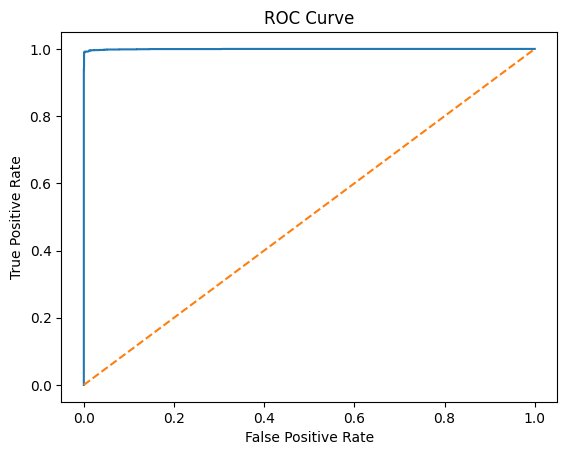

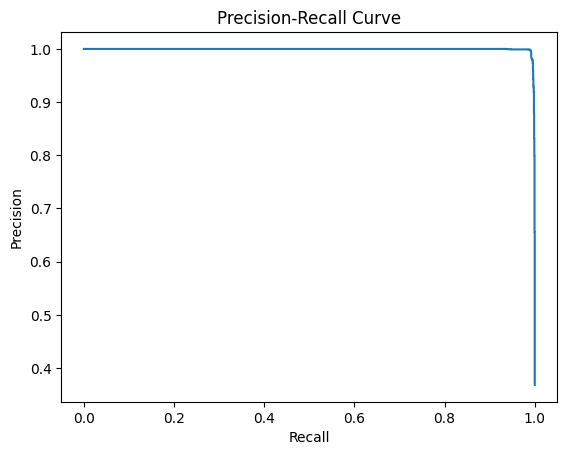

In [13]:
# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


Cross-Validation (Stratified)

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

cv_results = cross_validate(
    pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

print("Cross-validation results (mean):")
for s in scoring:
    print(f"{s:10s}: {cv_results[f'test_{s}'].mean():.4f}")


Cross-validation results (mean):
precision : 0.9966
recall    : 0.9946
f1        : 0.9956
roc_auc   : 0.9997


Подбор оптимального threshold

In [15]:
thresholds = np.linspace(0.1, 0.9, 50)

best = {"threshold": 0, "f1": 0}

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best["f1"]:
        best = {"threshold": t, "f1": f1}

best


{'threshold': np.float64(0.7367346938775511), 'f1': 0.9940515532055518}

Интерпретируемость (топ-признаки)

In [16]:
tfidf_features = pipeline.named_steps["features"] \
    .transformer_list[0][1] \
    .get_feature_names_out()

coefs = pipeline.named_steps["clf"].coef_[0]

top_features = sorted(
    zip(tfidf_features, coefs),
    key=lambda x: abs(x[1]),
    reverse=True
)[:20]

for f, w in top_features:
    print(f"{f:15s} {w:.4f}")


 (              0.1948
 )              0.1803
5.1             -0.1184
7a7             -0.1154
ct              -0.1149
lect            -0.1128
ect             -0.1125
ct *            -0.1117
ect *           -0.1117
sel             -0.1112
ele             -0.1105
t *             -0.1095
0e+15           -0.1082
ive             -0.1010
+15             -0.0999
e+15            -0.0999
car             -0.0985
end             0.0958
met             -0.0956
ble t           0.0923


Сохранение модели

In [17]:
joblib.dump(pipeline, "sql_injection_model.pkl")


['sql_injection_model.pkl']

Inference (демо)

ВАЖНО!ё!!!!!!!!!!!!!


Decision threshold был увеличен относительно стандартного 0.5
с целью снижения false positive rate для легитимных SQL-запросов,
что особенно важно для production-систем.

In [18]:
def detect_sql_injection(query, threshold=0.7367346938775511): # BEFORE 0.5 - BASIC; AFTER - ~0.7367346938775511
    prob = pipeline.predict_proba([query])[0][1]
    return {
        "query": query,
        "is_injection": prob >= threshold,
        "confidence": round(float(prob), 4)
    }

tests = [
    "SELECT r.name AS restaurant, d.name AS dish, SUM(oi.qty) AS total_ordered FROM order_items oi JOIN dishes d ON oi.dish_id = d.id JOIN restaurants r ON d.restaurant_id = r.id JOIN orders o ON oi.order_id = o.id WHERE o.status IN ('completed', 'served') GROUP BY r.name, d.name ORDER BY r.name, total_ordered DESC",

    "SELECT r.name AS restaurant, d.name AS dish FROM dishes d JOIN restaurants r ON d.restaurant_id = r.id LEFT JOIN order_items oi ON d.id = oi.dish_id WHERE oi.dish_id IS NULL ORDER BY r.name, d.name",

    "SELECT r.name AS restaurant, d.name AS dish FROM dishes d JOIN restaurants r ON d.restaurant_id = r.id WHERE d.is_available = FALSE ORDER BY r.name, d.name",

    "SELECT r.name AS restaurant, EXTRACT(HOUR FROM o.order_time) AS hour_of_day, COUNT(*) AS order_count FROM orders o JOIN restaurants r ON o.restaurant_id = r.id WHERE o.status IN ('completed', 'served') GROUP BY r.name, hour_of_day ORDER BY r.name, order_count DESC",

    "SELECT r.name AS restaurant, COUNT(*) AS order_count FROM orders o JOIN restaurants r ON o.restaurant_id = r.id WHERE o.status IN ('completed', 'served') AND EXTRACT(HOUR FROM o.order_time) BETWEEN 18 AND 20 GROUP BY r.name ORDER BY order_count DESC",

    "SELECT e.full_name AS employee, COUNT(DISTINCT o.id) AS orders_handled FROM orders o JOIN app_users au ON o.created_by_user = au.id JOIN employees e ON au.employee_id = e.id WHERE o.status IN ('completed', 'served') GROUP BY e.full_name ORDER BY orders_handled DESC",

    "SELECT e.full_name AS employee, COALESCE(SUM(o.total_amount), 0) AS total_revenue FROM orders o JOIN app_users au ON o.created_by_user = au.id JOIN employees e ON au.employee_id = e.id WHERE o.status IN ('completed', 'served') GROUP BY e.full_name ORDER BY total_revenue DESC",

    "SELECT i.name AS ingredient, SUM(di.qty_required * oi.qty) AS total_used FROM order_items oi JOIN dishes d ON oi.dish_id = d.id JOIN dish_ingredients di ON d.id = di.dish_id JOIN ingredients i ON di.ingredient_id = i.id JOIN orders o ON oi.order_id = o.id WHERE o.status IN ('completed', 'served') GROUP BY i.name ORDER BY total_used DESC",

    "SELECT EXTRACT(HOUR FROM o.order_time) AS hour_of_day, SUM(oi.qty) AS total_dishes FROM orders o JOIN order_items oi ON o.id = oi.order_id WHERE o.status IN ('completed', 'served') GROUP BY hour_of_day ORDER BY total_dishes DESC LIMIT 1",

    "SELECT d_unavail.name AS unavailable_dish, r.name AS restaurant, alt.name AS alternative_dish FROM dishes d_unavail JOIN restaurants r ON d_unavail.restaurant_id = r.id JOIN LATERAL (SELECT * FROM fn_suggest_alternatives(d_unavail.id, r.id, 3)) alt ON true WHERE d_unavail.is_available = FALSE",

    "SELECT d.name AS dish_name, r.name AS restaurant_name, d.category, DATE(o.order_time) AS order_date, SUM(oi.qty) AS daily_quantity, COUNT(DISTINCT o.id) AS daily_orders FROM orders o JOIN order_items oi ON o.id = oi.order_id JOIN dishes d ON oi.dish_id = d.id JOIN restaurants r ON d.restaurant_id = r.id WHERE o.status IN ('completed', 'served') AND o.order_time >= now() - INTERVAL '90 days' GROUP BY d.name, r.name, d.category, DATE(o.order_time) ORDER BY r.name, d.name, order_date",

    "SELECT d.name AS dish_name, EXTRACT(DOW FROM o.order_time) AS day_of_week, AVG(oi.qty) AS avg_qty_per_order, SUM(oi.qty) AS total_qty, COUNT(*) AS total_orders FROM orders o JOIN order_items oi ON o.id = oi.order_id JOIN dishes d ON oi.dish_id = d.id WHERE o.status IN ('completed', 'served') GROUP BY d.name, day_of_week ORDER BY d.name, day_of_week",

    "SELECT r.name AS restaurant, d.category, SUM(oi.qty * oi.price_at_order) AS category_revenue FROM order_items oi JOIN dishes d ON oi.dish_id = d.id JOIN restaurants r ON d.restaurant_id = r.id JOIN orders o ON oi.order_id = o.id WHERE o.status IN ('completed', 'served') GROUP BY r.name, d.category ORDER BY r.name, category_revenue DESC",

    "SELECT r.name AS restaurant, d.name AS dish, SUM(oi.qty * oi.price_at_order) AS total_revenue FROM order_items oi JOIN dishes d ON oi.dish_id = d.id JOIN restaurants r ON d.restaurant_id = r.id JOIN orders o ON oi.order_id = o.id WHERE o.status IN ('completed', 'served') GROUP BY r.name, d.name ORDER BY total_revenue DESC LIMIT 10",

    "WITH popular_dishes AS (SELECT d.id FROM order_items oi JOIN dishes d ON oi.dish_id = d.id JOIN orders o ON oi.order_id = o.id WHERE o.status IN ('completed', 'served') GROUP BY d.id ORDER BY SUM(oi.qty) DESC LIMIT 10) SELECT i.name AS ingredient, SUM(di.qty_required * oi.qty) AS total_used_in_popular FROM order_items oi JOIN dishes d ON oi.dish_id = d.id JOIN dish_ingredients di ON d.id = di.dish_id JOIN ingredients i ON di.ingredient_id = i.id JOIN orders o ON oi.order_id = o.id JOIN popular_dishes pd ON d.id = pd.id WHERE o.status IN ('completed', 'served') GROUP BY i.name ORDER BY total_used_in_popular DESC",

    "SELECT e.full_name, u.username, aur.restaurant_id, ar.name AS role FROM employees e JOIN app_users u ON e.id = u.employee_id JOIN app_user_roles aur ON u.id = aur.user_id JOIN app_roles ar ON aur.role_id = ar.id ORDER BY e.full_name",

    "SELECT u.username, ar.name AS role, r.name AS restaurant FROM app_user_roles aur JOIN app_users u ON aur.user_id = u.id JOIN app_roles ar ON aur.role_id = ar.id LEFT JOIN restaurants r ON aur.restaurant_id = r.id ORDER BY u.username",

    "SELECT o.id AS order_id, r.name AS restaurant, e.full_name AS waiter_name, o.guest_name, o.order_time, o.status FROM orders o JOIN restaurants r ON o.restaurant_id = r.id JOIN app_users au ON o.created_by_user = au.id JOIN employees e ON au.employee_id = e.id WHERE e.position = 'Официант' ORDER BY o.order_time DESC",

    "SELECT id, restaurant_id, name FROM dishes ORDER BY id",

    "UPDATE ingredient_batches SET min_threshold = 100 WHERE ingredient_id = 5 AND restaurant_id = 1",

    "UPDATE ingredient_batches SET qty = 300 WHERE ingredient_id = 5 AND restaurant_id = 1",

    "INSERT INTO orders (restaurant_id, guest_name, status, created_by_user) VALUES (1, 'Тест заявки', 'created', (SELECT id FROM app_users WHERE username = 'waiter1')) RETURNING id",

    "INSERT INTO order_items (order_id, dish_id, qty, price_at_order) VALUES (31, 2, 2, 700)",

    "SELECT fn_finalize_order(31)",

    "SELECT * FROM purchase_requests WHERE restaurant_id = 1 AND ingredient_id = 5",

    "UPDATE ingredient_batches SET qty = 0, active = FALSE WHERE ingredient_id = 9 AND restaurant_id = 2",

    "SELECT fn_update_dishes_availability_for_restaurant(2)",

    "INSERT INTO orders (restaurant_id, table_id, guest_name, status, created_by_user, order_time) VALUES (2, 1, 'Тест: Недоступная пицца', 'created', (SELECT id FROM app_users WHERE username = 'waiter3'), '2025-12-22 11:00:00') RETURNING id",

    "INSERT INTO order_items (order_id, dish_id, qty, price_at_order) VALUES (32, 6, 1, 800)",

    "SELECT * FROM fn_suggest_alternatives(6, 2)"
]


for t in tests:
    print(detect_sql_injection(t))


{'query': "SELECT r.name AS restaurant, d.name AS dish, SUM(oi.qty) AS total_ordered FROM order_items oi JOIN dishes d ON oi.dish_id = d.id JOIN restaurants r ON d.restaurant_id = r.id JOIN orders o ON oi.order_id = o.id WHERE o.status IN ('completed', 'served') GROUP BY r.name, d.name ORDER BY r.name, total_ordered DESC", 'is_injection': np.False_, 'confidence': 0.0}
{'query': 'SELECT r.name AS restaurant, d.name AS dish FROM dishes d JOIN restaurants r ON d.restaurant_id = r.id LEFT JOIN order_items oi ON d.id = oi.dish_id WHERE oi.dish_id IS NULL ORDER BY r.name, d.name', 'is_injection': np.False_, 'confidence': 0.0}
{'query': 'SELECT r.name AS restaurant, d.name AS dish FROM dishes d JOIN restaurants r ON d.restaurant_id = r.id WHERE d.is_available = FALSE ORDER BY r.name, d.name', 'is_injection': np.False_, 'confidence': 0.0}
{'query': "SELECT r.name AS restaurant, EXTRACT(HOUR FROM o.order_time) AS hour_of_day, COUNT(*) AS order_count FROM orders o JOIN restaurants r ON o.restaur